In [1]:
# import the necessary libraries

# For data augmentation while data preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pretrained MobileNet model.
from tensorflow.keras.applications import MobileNetV2

# Performing MaxPooling operations
from tensorflow.keras.layers import MaxPooling2D

# For performing dropout operation
from tensorflow.keras.layers import Dropout

# For flattening operation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# Input() is used to instantiate a Keras tensor.
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# We use adam optimizer
from tensorflow.keras.optimizers import Adam

# Preprocesses a tensor or Numpy array encoding a batch of images.
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Converts a PIL Image instance to a Numpy array.
from tensorflow.keras.preprocessing.image import img_to_array

# Loads an image into PIL format.
from tensorflow.keras.preprocessing.image import load_img

# Converts a class vector (integers) to binary class matrix.
from tensorflow.keras.utils import to_categorical

# Binarize labels in a one-vs-all fashion.
from sklearn.preprocessing import LabelBinarizer

# Performing train-test split
from sklearn.model_selection import train_test_split

# For printing the metrics
from sklearn.metrics import classification_report

# For using strings in file structure path format
from imutils import paths

# For plotting losse functions
import matplotlib.pyplot as plt

# For performing mathematical computations
import numpy as np

# For file-related operations
import os

2024-03-21 12:19:33.645673: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Path to directory containing data
DataDir = "cars_ds"

# Path to training directory
train_dir = os.path.join(DataDir, 'training/')

# Path to validation directory
val_dir = os.path.join(DataDir, 'validation/')

# Path for damaged training images
train_damage = os.path.join(train_dir, '00-damage')
# Path for training images not damaged
train_not_damage = os.path.join(val_dir, '01-whole')

# Number of damaged training images
num_train_damage = len(os.listdir(train_damage))

# Number of training images not damaged
num_train_not_damage = len(os.listdir(train_not_damage))

# Path for damaged validation
val_damage = os.path.join(val_dir, '00-damage')

# Path for validation images not damaged
val_not_damage = os.path.join(val_dir, '01-whole')

# Number of damaged validation images
num_val_damage = len(os.listdir(val_damage))

# Number of validation images not damaged
num_val_not_damage = len(os.listdir((val_not_damage)))

# Number of training images
num_train = num_train_damage + num_train_not_damage

# Number of validation images
num_val = num_val_damage + num_val_not_damage

In [3]:

# Total images
total_images = num_val + num_train
print("Total training images",num_train)
print("Total training images (Damaged)", num_train_damage)
print("Total training images (Damaged)", num_train_not_damage)
print()

print("Total validation images", num_val)
print("Total training images (Damaged)", num_val_damage)
print("Total training images (Damaged)", num_val_not_damage)
print()

print("Total Number of Images: ",total_images)

Total training images 1150
Total training images (Damaged) 920
Total training images (Damaged) 230

Total validation images 460
Total training images (Damaged) 230
Total training images (Damaged) 230

Total Number of Images:  1610


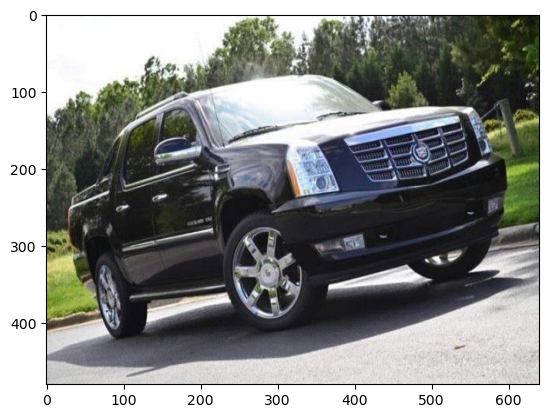

In [4]:
# Plotting a sample image
plt.grid('')
image = plt.imread('cars_ds/training/01-whole/0195.jpg')
plt.imshow(image)
plt.show()

In [5]:
# initializing the hyperparameters
initial_lr = 0.001
epochs = 10
batch_size = 64

# Classes which are detected
classes = ["00-damage", "01-whole"]

In [6]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

# It stores the data or feature set
data = []

# It stores the corrosponding labels
labels = []

for class_ in classes:
    path = os.path.join(train_dir, class_)
    for image in os.listdir(path):
    	image_path = os.path.join(path, image)
    	image_ = load_img(image_path, target_size=(224, 224))
    	image_ = img_to_array(image_)
    	image_ = preprocess_input(image_)

    	data.append(image_)
    	labels.append(class_)


for class_ in classes:
    path = os.path.join(val_dir, class_)
    for image in os.listdir(path):
    	image_path = os.path.join(path, image)
    	image_ = load_img(image_path, target_size=(224, 224))
    	image_ = img_to_array(image_)
    	image_ = preprocess_input(image_)

    	data.append(image_)
    	labels.append(class_)
        
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)



(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

[INFO] loading images...


In [7]:
# loading the MobileNetV2 network, ensuring the topmost fully-connected
# layer sets are left off
model_base = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# Constructing the top architecture of our model, which is placed over the 
# pretrained model
model_head = model_base.output
# MaxPooling layer

model_head = MaxPooling2D(pool_size=(5, 5))(model_head)
# Flatten layer
model_head = Flatten(name="flatten")(model_head)

# Activation function relu
model_head = Dense(128, activation="relu")(model_head)

# Performing dropout
model_head = Dropout(0.5)(model_head)

# Final output layer consists of softmax layer
model_head = Dense(2, activation="softmax")(model_head)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model_final = Model(inputs=model_base.input, outputs=model_head)

/var/folders/wb/m8jjr46910vf3x9p4gl6r7k40000gn/T/ipykernel_27875/805605193.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model_base = MobileNetV2(weights="imagenet", include_top=False,


In [8]:
# looping over all the layers and setting each individual layer trainability
# to false.
for layer in model_base.layers:
	layer.trainable = False

In [9]:
# Setting optimizer to Adam 
optim = Adam(learning_rate=initial_lr, decay=initial_lr / epochs)

# Compiling our model
model_final.compile(loss="binary_crossentropy", optimizer=optim,
	metrics=["accuracy"])

/Users/fardinhaque/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [10]:
# train the head of the network
model_train = model_final.fit(
#     Generates image generator from ImageGeneratorClass for inputing images in batches
	aug.flow(trainX, trainY, batch_size=batch_size),
#     Number of steps to be taken in one epoch over image batches
	steps_per_epoch=len(trainX) // batch_size,
#     Validation data
	validation_data=(testX, testY),
    
#     Steps for validation data
	validation_steps=len(testX) // batch_size,
    
#     Number of epochs
	epochs=epochs)

Epoch 1/10


/Users/fardinhaque/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.6097 - loss: 2.2964 - val_accuracy: 0.8196 - val_loss: 0.4526
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6875 - loss: 0.2898 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10


2024-03-21 12:20:46.092538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/fardinhaque/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-21 12:20:46.112649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


28/28 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7909 - loss: 0.4699 - val_accuracy: 0.8457 - val_loss: 0.3761
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8125 - loss: 0.2265 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10


2024-03-21 12:21:39.835597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-21 12:21:39.845236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


28/28 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8116 - loss: 0.4288 - val_accuracy: 0.8609 - val_loss: 0.3139
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8438 - loss: 0.1780 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10


2024-03-21 12:22:32.775129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-21 12:22:32.783275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


28/28 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8593 - loss: 0.3692 - val_accuracy: 0.8457 - val_loss: 0.3367
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8281 - loss: 0.1763 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/10


2024-03-21 12:23:26.577258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-21 12:23:26.585400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


28/28 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8387 - loss: 0.3613 - val_accuracy: 0.8609 - val_loss: 0.3406
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8125 - loss: 0.2357 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


2024-03-21 12:24:22.565782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-21 12:24:22.574274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [11]:
# Now, we predict on test set.
predict = model_final.predict(testX, batch_size=batch_size)

# for each image in the test set we find the index of the
# label with corresponding largest predicted probability
predict_index = np.argmax(predict, axis=1)

# Displaying classification report
print(classification_report(testY.argmax(axis=1), predict_index,
	target_names=lb.classes_))

# Storing our model for further use.
model_final.save("Car_detection.h5")

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


              precision    recall  f1-score   support

   00-damage       0.95      0.77      0.85       230
    01-whole       0.80      0.96      0.88       230

    accuracy                           0.86       460
   macro avg       0.88      0.86      0.86       460
weighted avg       0.88      0.86      0.86       460



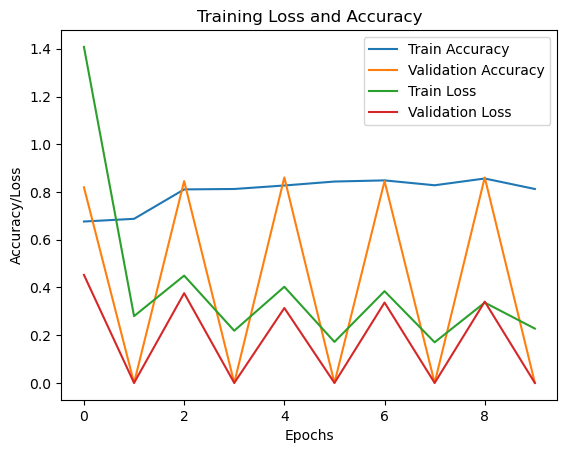

In [13]:
# plotting training loss and accuracy
num = epochs

# matplotlib style
#plt.style.use("seaborn")
plt.figure()

# Plotting all the required quantities
# Train Accuracy
plt.plot(np.arange(0, num), model_train.history["accuracy"], label="Train Accuracy")

# Validation Accuracy
plt.plot(np.arange(0, num), model_train.history["val_accuracy"], label="Validation Accuracy")

# Train Loss
plt.plot(np.arange(0, num), model_train.history["loss"], label="Train Loss")

# Validation Loss
plt.plot(np.arange(0, num), model_train.history["val_loss"], label="Validation Loss")

# Setting the title
plt.title("Training Loss and Accuracy")

# Setting the label
plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.legend(loc="upper right")

# Saving the Model
plt.savefig("Car_Detection.png")